## import base input targetlist

In [1]:
from astropy.io import ascii
from astropy.table import Table

# Load the target list
targetlist = ascii.read('/home/ariel/lorenzo.mugnai/USER_DATA/Alfnoor2/20250226 - NAOJ/week 3/20250314_ChanoulSeo_FourScenarioPlanets_MetaData.csv')

print(targetlist.keys())

# Initialize the output table with the same columns as the target list
out_targetlist = Table(names=targetlist.colnames, dtype=[targetlist[col].dtype for col in targetlist.colnames])



['Star Name', 'Star Mass [Ms]', 'Star Temperature [K]', 'Star Radius [Rs]', 'Star Distance [pc]', 'Star K Mag', 'Star V Mag', 'Star Metallicity', 'Star Age [Gyr]', 'Star RA', 'Star Dec', 'Planet Name', 'Planet Period [days]', 'Planet Temperature [K]', 'Planet Semi-major Axis [m]', 'Planet Radius [Re]', 'Planet Albedo', 'Planet Mass [Me]', 'Molecular Weight', 'Transit Duration [s]', 'Impact Parameter', 'Heat Redistribution Factor', 'Inclination', 'Eccentricity', 'Transit Mid Time', 'Tier', 'Best Method', 'Time [s]', 'Chemistry filename', 'Temperature filename', 'COratio', 'OHratio', 'HeHratio', 'IceoverFe', 'Redox [Oxidized = 0, Reduced = 1]', 'Migration Efficiency [ Inefficient = 0, Efficient = 1]']


## Load retrievals

In [ ]:
import h5py
import os
import numpy as np
from tqdm import tqdm
from astropy.table import Table

# Retrieval folder
retrieval_folder = "./retrievals/Tier1"

# Dictionary to track additional columns dynamically discovered in HDF5 files
additional_columns = {}

# First pass: Identify available data and new columns
valid_planets = []  # Store planets that have an HDF5 file

for i, planet in tqdm(enumerate(targetlist["Planet Name"]), total=len(targetlist)):
    path = os.path.join(retrieval_folder, planet)
    file = os.path.join(path, f"{planet}_retrieval.hdf5")

    if not os.path.exists(file):
        print("-> File not found:", planet)
        continue  # Skip planets without an associated file

    valid_planets.append(i)  # Store index of valid planets
    print("Valid planet:", planet)

    # Open the HDF5 file to discover new columns
    with h5py.File(file, 'r') as f:
        solution_path = "Output/Solutions/solution0/fit_params"
        if solution_path in f:
            additional_columns["H2/He"] = f["ModelParameters/Chemistry/ratio"][()].dtype
            for key in f[solution_path].keys():
                additional_columns[key] = f[f"{solution_path}/{key}/value"][()].dtype
                additional_columns[key+"_sigma_p"] = f[f"{solution_path}/{key}/sigma_p"][()].dtype
                additional_columns[key+"_sigma_m"] = f[f"{solution_path}/{key}/sigma_m"][()].dtype
                
print(f"found {len(valid_planets)} valid planets")

# Initialize `out_targetlist` with only valid planets (ones that have a file)
out_targetlist = Table(
    names=targetlist.colnames, 
    dtype=[targetlist[col].dtype for col in targetlist.colnames]
)

# Ensure all additional columns exist in `out_targetlist`
for col_name, col_dtype in additional_columns.items():
    if col_name not in out_targetlist.colnames:
        if np.issubdtype(col_dtype, np.number):
            out_targetlist[col_name] = np.full(0, np.nan, dtype=col_dtype)
        else:
            out_targetlist[col_name] = np.full(0, "", dtype="U20")  # Default string length of 20

# Second pass: Extract data for valid planets and add them to `out_targetlist`
for i in tqdm(valid_planets, total=len(valid_planets)):
    planet = targetlist["Planet Name"][i]
    path = os.path.join(retrieval_folder, planet)
    file = os.path.join(path, f"{planet}_retrieval.hdf5")

    # Create a dictionary with the planet's existing metadata
    planet_data = {col: targetlist[i][col] for col in targetlist.colnames}

    # Open the HDF5 file
    with h5py.File(file, 'r') as f:
        solution_path = "Output/Solutions/solution0/fit_params"
        if solution_path in f:
            planet_data["H2/He"] = f["ModelParameters/Chemistry/ratio"][()]
            for key in f[solution_path].keys():
                planet_data[key] = f[f"{solution_path}/{key}/value"][()]
                planet_data[key+"_sigma_p"] = f[f"{solution_path}/{key}/sigma_p"][()]
                planet_data[key+"_sigma_m"] = f[f"{solution_path}/{key}/sigma_m"][()]

    # Ensure missing columns are filled with NaN or empty strings
    for col in out_targetlist.colnames:
        if col not in planet_data:
            if np.issubdtype(out_targetlist[col].dtype, np.integer):
                planet_data[col] = -1  # Assign a default integer value instead of NaN
            elif np.issubdtype(out_targetlist[col].dtype, np.number):
                planet_data[col] = np.nan  # Assign NaN for missing numerical values
            else:
                planet_data[col] = ""  # Assign empty string for missing text values

    # Add the row to `out_targetlist`
    out_targetlist.add_row([planet_data[col] for col in out_targetlist.colnames])

# Print final table length (should match number of valid planets)
print(len(out_targetlist))  # Should be <= len(targetlist), only including valid ones


100%|██████████| 40/40 [00:00<00:00, 357.29it/s]


Valid planet: Planet2116
Valid planet: Planet4458
Valid planet: Planet1469
Valid planet: Planet20081
-> File not found: Planet16362
Valid planet: Planet16519
Valid planet: Planet19196
Valid planet: Planet11276
-> File not found: Planet9906
Valid planet: Planet2345
Valid planet: Planet414788
Valid planet: Planet239469
Valid planet: Planet12188
Valid planet: Planet416612
Valid planet: Planet389005
Valid planet: Planet18
Valid planet: Planet394093
-> File not found: Planet209769
-> File not found: Planet1283
Valid planet: Planet167068
Valid planet: Planet146072
Valid planet: Planet105702
Valid planet: Planet100307
Valid planet: Planet21984
Valid planet: Planet164267
Valid planet: Planet154053
Valid planet: Planet149593
Valid planet: Planet90462
Valid planet: Planet46851
Valid planet: Planet168373
Valid planet: Planet33114
Valid planet: Planet10
-> File not found: Planet84437
Valid planet: Planet47692
Valid planet: Planet46559
Valid planet: Planet64844
Valid planet: Planet81471
Valid plane

 35%|███▌      | 12/34 [00:00<00:00, 115.21it/s]

100%|██████████| 34/34 [00:00<00:00, 115.91it/s]

34


In [3]:
idx = [i for i, name in enumerate(targetlist["Planet Name"]) if name not in out_targetlist["Planet Name"]]
print(idx)

targetlist[idx]

[4, 8, 17, 18, 32, 38]


Star Name,Star Mass [Ms],Star Temperature [K],Star Radius [Rs],Star Distance [pc],Star K Mag,Star V Mag,Star Metallicity,Star Age [Gyr],Star RA,Star Dec,Planet Name,Planet Period [days],Planet Temperature [K],Planet Semi-major Axis [m],Planet Radius [Re],Planet Albedo,Planet Mass [Me],Molecular Weight,Transit Duration [s],Impact Parameter,Heat Redistribution Factor,Inclination,Eccentricity,Transit Mid Time,Tier,Best Method,Time [s],Chemistry filename,Temperature filename,COratio,OHratio,HeHratio,IceoverFe,"Redox [Oxidized = 0, Reduced = 1]","Migration Efficiency [ Inefficient = 0, Efficient = 1]"
str6,float64,int64,float64,int64,float64,float64,float64,int64,int64,int64,str12,float64,float64,int64,float64,float64,float64,float64,float64,float64,int64,int64,float64,int64,int64,str7,int64,str53,str47,float64,float64,int64,float64,int64,int64
Star5,1.0,5649,0.91,10,3.58,5.13,1.405286907,1,0,0,Planet16362,9.36541,879.891,13014302400,2.70734,0.1,5.22967,17.82502331,11153.33353,0.5,1,90,0.0198797,0,2,Transit,10,./20250314_CompoProfile/Planet16362_Compoprofile.csv,./20250314_PTprofile/Planet16362_PTprofile.csv,7.85e-05,0.494455439,0,12.16768773,0,1
Star9,1.0,5649,0.91,10,3.58,5.13,2.158330759,1,0,0,Planet9906,176.74,330.222,92248596000,2.69832,0.1,2.47023,15.30558355,29683.23879,0.5,1,90,0.0252921,0,2,Transit,10,./20250314_CompoProfile/Planet9906_Compoprofile.csv,./20250314_PTprofile/Planet9906_PTprofile.csv,0.000260165,0.415619645,0,12.19875323,0,1
Star18,1.0,5649,0.91,10,3.58,5.13,1.603688445,1,0,0,Planet209769,75.1787,439.216,52175543200,2.6447,0.1,16.429,4.650569145,22350.45968,0.5,1,90,0.0635387,0,2,Transit,10,./20250314_CompoProfile/Planet209769_Compoprofile.csv,./20250314_PTprofile/Planet209769_PTprofile.csv,0.066896475,0.081159415,0,0.0,0,0
Star19,1.0,5649,0.91,10,3.58,5.13,0.914378067,1,0,0,Planet1283,109.186,387.925,66913686400,2.72277,0.1,19.0292,17.61192174,25285.48184,0.5,1,90,0.0229848,0,2,Transit,10,./20250314_CompoProfile/Planet1283_Compoprofile.csv,./20250314_PTprofile/Planet1283_PTprofile.csv,0.00053854,0.487370983,0,7.48984951,0,0
Star33,0.3,3443,0.29,10,8.21,9.75,0.623406032,1,0,0,Planet84437,15.4162,314.469,12145844480,2.21221,0.1,4.15419,6.0639022,6526.470453,0.5,1,90,0.0173491,0,2,Transit,10,./20250314_CompoProfile/Planet84437_Compoprofile.csv,./20250314_PTprofile/Planet84437_PTprofile.csv,0.004525473,0.126705662,0,2.025436827,0,0
Star39,0.3,3443,0.29,10,8.21,9.75,1.022943436,1,0,0,Planet65890,11.9571,342.264,10253195040,2.18883,0.1,5.50717,3.057766811,5993.104165,0.5,1,90,0.0227461,0,2,Transit,10,./20250314_CompoProfile/Planet65890_Compoprofile.csv,./20250314_PTprofile/Planet65890_PTprofile.csv,0.026101359,0.032941527,0,0.0,0,0


## load Ariel's data

In [4]:
import astropy.units as u

# Ensure the required columns exist in out_targetlist
for col in ["nobs", "obs_time"]:
    if col not in out_targetlist.colnames:
        out_targetlist[col] = np.nan  # Initialize missing columns

forwards_folder = "./forwards/ArielInstrumentTier2"
for i, planet_data in tqdm(enumerate(out_targetlist), total=len(out_targetlist)):
    planet_dict = {col: planet_data[col] for col in out_targetlist.colnames}

    fname = os.path.join(forwards_folder, f"{planet_dict['Planet Name']}/{planet_dict['Planet Name']}.hdf5")
    if not os.path.isfile(fname):
        print("File not found:", planet_dict['Planet Name'])
        continue
    
    with h5py.File(fname, 'r') as f:
        ariel_path = f["Output/Spectra"]
        planet_dict["nobs"] = ariel_path["instrument_nobs"][()]
        planet_dict["obs_time"] = planet_dict['Transit Duration [s]'] * planet_dict["nobs"] * u.s.to(u.hr)

    # Ensure the row update follows the correct column order
    out_targetlist[i] = [planet_dict[col] for col in out_targetlist.colnames]


100%|██████████| 34/34 [00:00<00:00, 1092.26it/s]


## load profile data

In [5]:
comp_folders = ["/home/ariel/lorenzo.mugnai/USER_DATA/Alfnoor2/20250226 - NAOJ/week 3/20250314_CompoProfile"]

pt_folders = ["/home/ariel/lorenzo.mugnai/USER_DATA/Alfnoor2/20250226 - NAOJ/week 3/20250314_PTprofile"]

for col in ["H2_profile", "He_profile", "H2O_profile", "CO_profile", "CO2_profile", "CH4_profile", "T_profile"]:
    if col not in out_targetlist.colnames:
        out_targetlist[col] = np.nan  # In

print(out_targetlist.colnames)

def find_file(path, keyword):
    file_list = os.listdir(path)
    # print(file_list)
    # print(planet_data['Planet Name'].split("_")[0])

    matching_files = [file for file in file_list if keyword in file]
    # print(matching_files)
    return matching_files

for i, planet_data in tqdm(enumerate(out_targetlist), total=len(out_targetlist)):

    planet_dict = {col: planet_data[col] for col in out_targetlist.colnames}

    matching_files =find_file(comp_folders[0], planet_data['Planet Name'].split("_")[0])
    if matching_files:
        fname = os.path.join(comp_folders[0], matching_files[0])
    else:
        matching_files =find_file(comp_folders[1], planet_data['Planet Name'].split("_")[0])
        if matching_files:
            fname = os.path.join(comp_folders[1], matching_files[0])
        else:
            continue
        
    data = ascii.read(fname, format='no_header', delimiter=',', comment="#")

    column_map = ["H2", "H2O", "CO", "CO2", "CH4", "He"]
    data.rename_columns(data.colnames, column_map)
    for column in column_map:
        planet_dict[f"{column}_profile"] = np.median(data[column])    
    
    matching_files =find_file(pt_folders[0], planet_data['Planet Name'].split("_")[0])
    if matching_files:
        fname = os.path.join(pt_folders[0], matching_files[0])
    else:
        matching_files =find_file(pt_folders[1], planet_data['Planet Name'].split("_")[0])
        if matching_files:
            fname = os.path.join(pt_folders[1], matching_files[0])
        else:
            continue
    data = ascii.read(fname, format='no_header', delimiter=',', comment="#")
    planet_dict[f"T_profile"] = np.median(data["col2"])

    # Ensure the row update follows the correct column order
    out_targetlist[i] = [planet_dict[col] for col in out_targetlist.colnames]



['Star Name', 'Star Mass [Ms]', 'Star Temperature [K]', 'Star Radius [Rs]', 'Star Distance [pc]', 'Star K Mag', 'Star V Mag', 'Star Metallicity', 'Star Age [Gyr]', 'Star RA', 'Star Dec', 'Planet Name', 'Planet Period [days]', 'Planet Temperature [K]', 'Planet Semi-major Axis [m]', 'Planet Radius [Re]', 'Planet Albedo', 'Planet Mass [Me]', 'Molecular Weight', 'Transit Duration [s]', 'Impact Parameter', 'Heat Redistribution Factor', 'Inclination', 'Eccentricity', 'Transit Mid Time', 'Tier', 'Best Method', 'Time [s]', 'Chemistry filename', 'Temperature filename', 'COratio', 'OHratio', 'HeHratio', 'IceoverFe', 'Redox [Oxidized = 0, Reduced = 1]', 'Migration Efficiency [ Inefficient = 0, Efficient = 1]', 'H2/He', 'T', 'T_sigma_p', 'T_sigma_m', 'log_CH4', 'log_CH4_sigma_p', 'log_CH4_sigma_m', 'log_CO', 'log_CO_sigma_p', 'log_CO_sigma_m', 'log_CO2', 'log_CO2_sigma_p', 'log_CO2_sigma_m', 'log_H2O', 'log_H2O_sigma_p', 'log_H2O_sigma_m', 'planet_radius', 'planet_radius_sigma_p', 'planet_radius_s

100%|██████████| 34/34 [00:00<00:00, 169.55it/s]


## Compute metallicities

In [6]:
import sys
import os
import numpy as np
from tqdm import tqdm
from astropy.table import Table

# Add the current notebook's directory to the Python path
sys.path.append(os.getcwd())

# Now import the function
from mol_to_ratios import calculate_ratios_with_uncertainties

# Ensure the required columns exist in out_targetlist
for col in ["O/H", "O/H_sigma", "C/O", "C/O_sigma", "He/H", "He/H_sigma", 
            "He", "H2", "H2O", "CO", "CO2", "CH4", "H2O_sigma", "CO_sigma", "CO2_sigma", "CH4_sigma", "He_sigma", "H2_sigma", 
            "H", "C", "O", "H_sigma", "C_sigma", "O_sigma"]:
    if col not in out_targetlist.colnames:
        out_targetlist[col] = np.nan  # Initialize missing columns

# Iterate through each planet in the target list
for i, planet_data in tqdm(enumerate(out_targetlist), total=len(out_targetlist)):
    # Convert Row to a dictionary for easier modification
    planet_dict = {col: planet_data[col] for col in out_targetlist.colnames}

    # Retrieve molecular fractions and uncertainties from planet_dict
    try:
        ln10 = np.log(10)  # ln(10) ≈ 2.302

        H2O = 10**planet_dict.get("log_H2O", np.nan)
        CO = 10**planet_dict.get("log_CO", np.nan)
        CO2 = 10**planet_dict.get("log_CO2", np.nan)
        CH4 = 10**planet_dict.get("log_CH4", np.nan)

        sigma_H2O = ln10 * H2O * np.mean([planet_dict.get("log_H2O_sigma_p", np.nan), planet_dict.get("log_H2O_sigma_m", np.nan)])
        sigma_CO = ln10 * CO * np.mean([planet_dict.get("log_CO_sigma_p", np.nan), planet_dict.get("log_CO_sigma_m", np.nan)])
        sigma_CO2 = ln10 * CO2 * np.mean([planet_dict.get("log_CO2_sigma_p", np.nan), planet_dict.get("log_CO2_sigma_m", np.nan)])
        sigma_CH4 = ln10 * CH4 * np.mean([planet_dict.get("log_CH4_sigma_p", np.nan), planet_dict.get("log_CH4_sigma_m", np.nan)])

        planet_dict["H2O"] = H2O
        planet_dict["CO"] = CO
        planet_dict["CO2"] = CO2
        planet_dict["CH4"] = CH4
        planet_dict["H2O_sigma"] = sigma_H2O
        planet_dict["CO_sigma"] = sigma_CO
        planet_dict["CO2_sigma"] = sigma_CO2
        planet_dict["CH4_sigma"] = sigma_CH4
        
        # Retrieve precise H2/He ratio
        H2_He = planet_dict.get("H2/He", np.nan)

        # Compute elemental ratios
        ratios = calculate_ratios_with_uncertainties(H2_He, H2O, CO, CO2, CH4,
                                                    sigma_H2O, sigma_CO, 
                                                    sigma_CO2, sigma_CH4)

        # Add computed ratios to the planet dictionary
        planet_dict["O/H"] = ratios["O/H"][0]
        planet_dict["O/H_sigma"] = ratios["O/H"][1]
        planet_dict["C/O"] = ratios["C/O"][0]
        planet_dict["C/O_sigma"] = ratios["C/O"][1]
        planet_dict["He/H"] = ratios["He/H"][0]
        planet_dict["He/H_sigma"] = ratios["He/H"][1]
        planet_dict["He"] = ratios["He"][0]
        planet_dict["He_sigma"] = ratios["He"][1]
        planet_dict["H2"] = ratios["H2"][0]
        planet_dict["H2_sigma"] = ratios["H2"][1]
        planet_dict["H"] = ratios["H"][0]
        planet_dict["H_sigma"] = ratios["H"][1]
        planet_dict["C"] = ratios["C"][0]
        planet_dict["C_sigma"] = ratios["C"][1]
        planet_dict["O"] = ratios["O"][0]
        planet_dict["O_sigma"] = ratios["O"][1]

    except KeyError:
        pass  # If any key is missing, skip adding ratios

    # Ensure missing columns are set to NaN
    for col in out_targetlist.colnames:
        if col not in planet_dict:
            planet_dict[col] = np.nan

    # Ensure the row update follows the correct column order
    out_targetlist[i] = [planet_dict[col] for col in out_targetlist.colnames]
    
# Ensure the required columns exist in out_targetlist
for col in ["O/H_profile", "C/O_profile", "He/H_profile", "He_profile", "H2_profile", "H_profile", "C_profile", "O_profile"]:
    if col not in out_targetlist.colnames:
        out_targetlist[col] = np.nan  # Initialize missing columns

# Iterate through each planet in the target list
for i, planet_data in tqdm(enumerate(out_targetlist), total=len(out_targetlist)):
    # Convert Row to a dictionary for easier modification
    planet_dict = {col: planet_data[col] for col in out_targetlist.colnames}

    # Retrieve molecular fractions and uncertainties from planet_dict
    H2O = planet_dict.get("H2O_profile", np.nan)
    CO = planet_dict.get("CO_profile", np.nan)
    CO2 = planet_dict.get("CO2_profile", np.nan)
    CH4 = planet_dict.get("CH4_profile", np.nan)
    H2_He = 1e-100
    
    ratios = calculate_ratios_with_uncertainties(H2_He, H2O, CO, CO2, CH4)

    # Add computed ratios to the planet dictionary
    planet_dict["O/H_profile"] = ratios["O/H"]
    planet_dict["C/O_profile"] = ratios["C/O"]
    planet_dict["He/H_profile"] = ratios["He/H"]
    planet_dict["He_profile"] = ratios["He"]
    planet_dict["H2_profile"] = ratios["H2"]
    planet_dict["H_profile"] = ratios["H"]
    planet_dict["C_profile"] = ratios["C"]
    planet_dict["O_profile"] = ratios["O"]
    out_targetlist[i] = [planet_dict[col] for col in out_targetlist.colnames]





100%|██████████| 34/34 [00:00<00:00, 1858.38it/s]


## saving data

In [ ]:
print(out_targetlist.keys())
ascii.write(out_targetlist, 'Tier1_data_analyzed.csv', format='csv', overwrite=True)

['Star Name', 'Star Mass [Ms]', 'Star Temperature [K]', 'Star Radius [Rs]', 'Star Distance [pc]', 'Star K Mag', 'Star V Mag', 'Star Metallicity', 'Star Age [Gyr]', 'Star RA', 'Star Dec', 'Planet Name', 'Planet Period [days]', 'Planet Temperature [K]', 'Planet Semi-major Axis [m]', 'Planet Radius [Re]', 'Planet Albedo', 'Planet Mass [Me]', 'Molecular Weight', 'Transit Duration [s]', 'Impact Parameter', 'Heat Redistribution Factor', 'Inclination', 'Eccentricity', 'Transit Mid Time', 'Tier', 'Best Method', 'Time [s]', 'Chemistry filename', 'Temperature filename', 'COratio', 'OHratio', 'HeHratio', 'IceoverFe', 'Redox [Oxidized = 0, Reduced = 1]', 'Migration Efficiency [ Inefficient = 0, Efficient = 1]', 'H2/He', 'T', 'T_sigma_p', 'T_sigma_m', 'log_CH4', 'log_CH4_sigma_p', 'log_CH4_sigma_m', 'log_CO', 'log_CO_sigma_p', 'log_CO_sigma_m', 'log_CO2', 'log_CO2_sigma_p', 'log_CO2_sigma_m', 'log_H2O', 'log_H2O_sigma_p', 'log_H2O_sigma_m', 'planet_radius', 'planet_radius_sigma_p', 'planet_radius_s

# let's make some sense of the data

In [8]:
from astropy.table import Table
import pandas as pd
from IPython.display import display

df = out_targetlist.to_pandas()  


display(df[["O/H", "O/H_sigma", "C/O", "C/O_sigma", "He/H", "He/H_sigma", "H2O", "H2O_sigma","CO",  "CO_sigma", "CO2", "CO2_sigma","CH4",  "CH4_sigma", "H2_profile", "He_profile", "H2O_profile", "CO_profile", "CO2_profile", "CH4_profile", "T_profile"]])


display(df[["O/H", "O/H_sigma", "C/O", "C/O_sigma", "He/H", "He/H_sigma", "O/H_profile", "C/O_profile", "He/H_profile", "OHratio", "COratio", "HeHratio"]])


display(df[["Planet Temperature [K]", "T_profile", "T", "T_sigma_p"]])


,O/H,O/H_sigma,C/O,C/O_sigma,He/H,He/H_sigma,H2O,H2O_sigma,CO,CO_sigma,...,CO2_sigma,CH4,CH4_sigma,H2_profile,He_profile,H2O_profile,CO_profile,CO2_profile,CH4_profile,T_profile
0,0.280575,0.038986,0.002054,0.000546,1.068730e-100,1.757233e-101,0.561790,0.061146,2.935303e-06,1.790428e-05,...,8.230064e-07,1.150524e-03,2.791359e-04,0.388921,3.889212e-101,0.610099,8.308055e-13,7.430228e-11,9.802604e-04,551.946744
1,0.310969,0.029060,0.003217,0.000836,9.157403e-101,1.208690e-101,0.623184,0.043726,1.383417e-07,7.172487e-07,...,1.638841e-08,2.004734e-03,5.017952e-04,0.335037,3.350367e-101,0.662135,1.449468e-08,3.881778e-07,2.827612e-03,636.074000
2,0.333733,0.019727,0.003524,0.000865,8.025627e-101,7.742110e-102,0.669038,0.028752,3.095165e-07,1.783903e-06,...,1.464867e-08,2.357692e-03,5.694691e-04,0.295848,2.958479e-101,0.702037,1.638691e-11,1.745399e-09,2.115040e-03,544.033000
3,0.130542,0.014248,0.024005,0.007620,1.778274e-100,9.416188e-102,0.262726,0.026880,8.645286e-07,5.031566e-06,...,5.502485e-06,6.304399e-03,1.895025e-03,0.733796,7.337961e-101,0.261288,2.273537e-09,9.682566e-09,4.915492e-03,667.951878
4,0.322700,0.033631,0.000281,0.000480,8.676873e-101,1.360429e-101,0.645368,0.049681,6.363545e-05,3.073347e-04,...,1.750610e-06,1.163270e-04,3.674430e-05,0.129196,1.291963e-101,0.870606,1.040947e-25,1.116766e-20,1.974749e-04,318.095000
5,0.402654,0.031629,0.088518,0.055893,6.488196e-101,1.222143e-101,0.685880,0.016204,6.628528e-02,4.185272e-02,...,1.840681e-08,2.945461e-04,7.453631e-05,0.133421,1.334210e-101,0.866374,5.771686e-15,7.215125e-12,2.053372e-04,468.021000
6,0.337917,0.017492,0.000523,0.000136,7.918605e-101,6.808418e-102,0.676073,0.025299,7.820166e-08,3.614688e-07,...,3.834157e-09,3.532429e-04,9.101512e-05,0.255255,2.552550e-101,0.744446,2.486647e-23,3.141189e-19,2.989299e-04,351.471000
7,0.346399,0.008310,0.001578,0.001376,7.574140e-101,3.158146e-102,0.689857,0.011770,1.961645e-07,1.087133e-06,...,9.517661e-04,1.411116e-07,5.680164e-07,0.014116,1.411633e-102,0.985708,3.053718e-07,1.749753e-04,1.421234e-07,695.895000
8,0.040298,0.007785,0.023331,0.007104,2.241585e-100,6.200967e-102,0.080749,0.015499,5.440392e-08,2.499665e-07,...,2.338430e-08,1.883846e-03,4.453696e-04,0.932937,9.329372e-101,0.064878,2.862192e-24,6.045415e-22,2.185202e-03,440.526930
9,0.052290,0.006967,0.021104,0.005591,2.181273e-100,5.434947e-102,0.104811,0.013813,1.439562e-07,7.015293e-07,...,4.002932e-09,2.211786e-03,5.083950e-04,0.876961,8.769610e-101,0.120337,1.639409e-13,1.022176e-12,2.702081e-03,703.870099


,O/H,O/H_sigma,C/O,C/O_sigma,He/H,He/H_sigma,O/H_profile,C/O_profile,He/H_profile,OHratio,COratio,HeHratio
0,0.280575,0.038986,0.002054,0.000546,1.068730e-100,1.757233e-101,0.304751,0.001607,1.942702e-101,0.304751,0.001607,0
1,0.310969,0.029060,0.003217,0.000836,9.157403e-101,1.208690e-101,0.330135,0.004271,1.670461e-101,0.330135,0.004271,0
2,0.333733,0.019727,0.003524,0.000865,8.025627e-101,7.742110e-102,0.350278,0.003013,1.476117e-101,0.350278,0.003013,0
3,0.130542,0.014248,0.024005,0.007620,1.778274e-100,9.416188e-102,0.130005,0.018813,3.651034e-101,0.130005,0.018813,0
4,0.322700,0.033631,0.000281,0.000480,8.676873e-101,1.360429e-101,0.435217,0.000227,6.458539e-102,0.435217,0.000227,0
5,0.402654,0.031629,0.088518,0.055893,6.488196e-101,1.222143e-101,0.433098,0.000237,6.669683e-102,0.433098,0.000237,0
6,0.337917,0.017492,0.000523,0.000136,7.918605e-101,6.808418e-102,0.372112,0.000402,1.275893e-101,0.372112,0.000402,0
7,0.346399,0.008310,0.001578,0.001376,7.574140e-101,3.158146e-102,0.493116,0.000178,7.059401e-103,0.493116,0.000178,0
8,0.040298,0.007785,0.023331,0.007104,2.241585e-100,6.200967e-102,0.032368,0.033682,4.654515e-101,0.032368,0.033682,0
9,0.052290,0.006967,0.021104,0.005591,2.181273e-100,5.434947e-102,0.060006,0.022454,4.372989e-101,0.060006,0.022454,0


,Planet Temperature [K],T_profile,T,T_sigma_p
0,536.373,551.946744,493.528564,34.901131
1,636.074,636.074000,589.436595,21.802398
2,544.033,544.033000,539.154987,22.624995
3,657.453,667.951878,690.287751,36.917705
4,318.095,318.095000,267.769859,16.582614
5,468.021,468.021000,445.901201,19.255940
6,351.471,351.471000,321.131630,14.666019
7,695.895,695.895000,522.147661,17.151824
8,369.951,440.526930,404.102810,21.790310
9,558.889,703.870099,520.626982,22.987283


# Let's do some plotting now

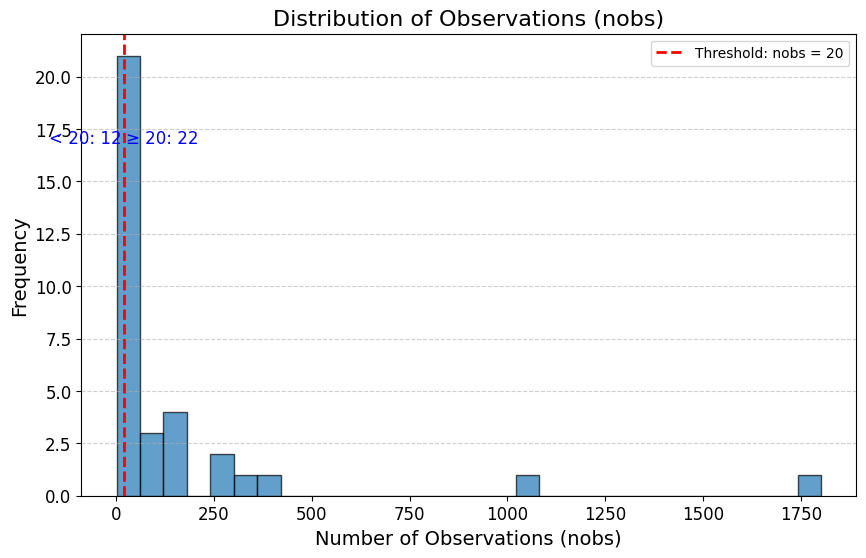

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Extract data for the histogram
nobs_data = np.array(out_targetlist["nobs"])

# Define binning for more granularity
bins = 30  

# Create the figure and axis
plt.figure(figsize=(10, 6))

# Plot histogram
counts, bin_edges, _ = plt.hist(nobs_data, bins=bins, edgecolor="black", alpha=0.7)

# Add a vertical line at nobs = 20
plt.axvline(x=20, color="red", linestyle="--", linewidth=2, label="Threshold: nobs = 20")

# Count elements before and after nobs = 20
below_threshold = np.sum(nobs_data < 20)
above_threshold = np.sum(nobs_data >= 20)

# Annotate the counts
plt.text(15, max(counts) * 0.8, f"< 20: {below_threshold}", color="blue", fontsize=12, ha="right")
plt.text(25, max(counts) * 0.8, f"≥ 20: {above_threshold}", color="blue", fontsize=12, ha="left")

# Labels and title
plt.xlabel("Number of Observations (nobs)", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.title("Distribution of Observations (nobs)", fontsize=16)

# Improve readability
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.legend()

# Show the plot
plt.show()



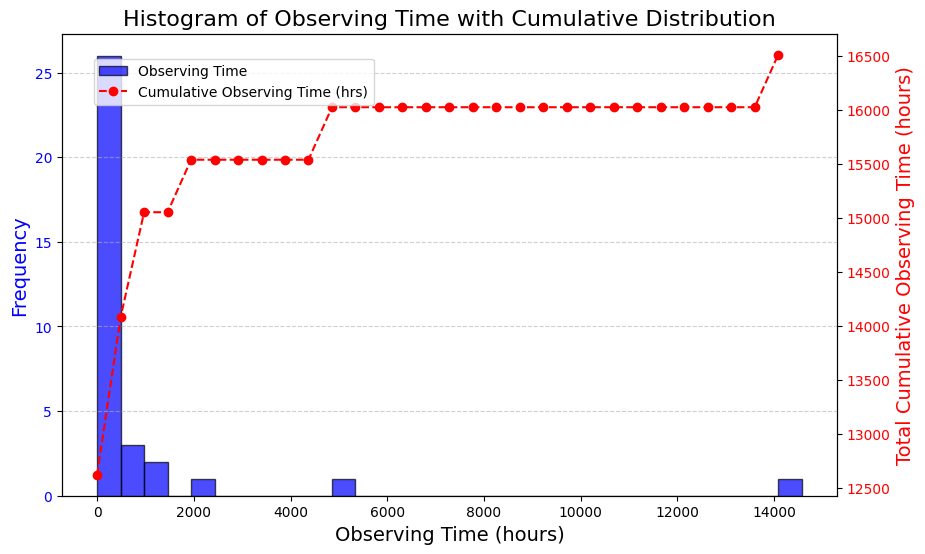

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Extract data for the histogram
obs_time_data = np.array(out_targetlist["obs_time"])  # Replace with correct column name if different

# Define binning
bins = 30  

# Create figure and axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot histogram
counts, bin_edges, _ = ax1.hist(obs_time_data, bins=bins, edgecolor="black", alpha=0.7, label="Observing Time", color="blue")

# Compute cumulative distribution
cumulative_hours = np.cumsum(counts * np.diff(bin_edges))  # Multiply bin count by bin width to get total hours

# Create second Y-axis for cumulative curve
ax2 = ax1.twinx()
ax2.plot(bin_edges[:-1], cumulative_hours, color="red", linestyle="--", marker="o", label="Cumulative Observing Time (hrs)")

# Labels and title
ax1.set_xlabel("Observing Time (hours)", fontsize=14)
ax1.set_ylabel("Frequency", fontsize=14, color="blue")
ax2.set_ylabel("Total Cumulative Observing Time (hours)", fontsize=14, color="red")
plt.title("Histogram of Observing Time with Cumulative Distribution", fontsize=16)

# Improve readability
ax1.tick_params(axis="y", labelcolor="blue")
ax2.tick_params(axis="y", labelcolor="red")
ax1.grid(axis="y", linestyle="--", alpha=0.6)

# Legend
fig.legend(loc="upper left", bbox_to_anchor=(0.15, 0.85))

# Show the plot
plt.show()


## validate retrieval

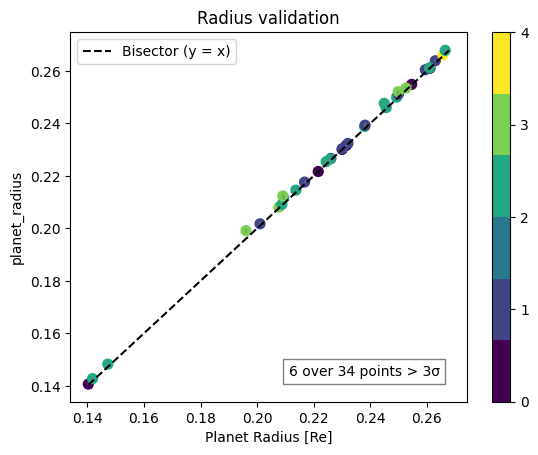

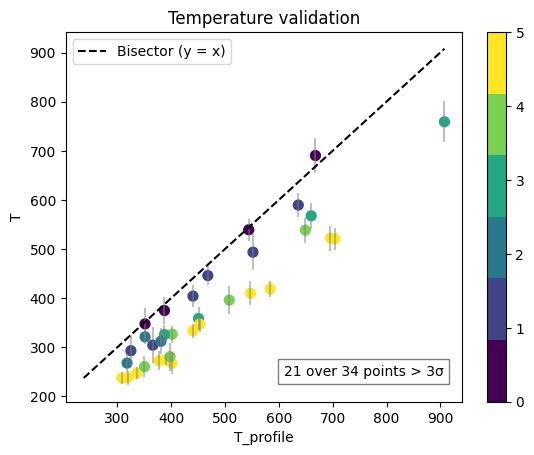

In [11]:
import matplotlib.pyplot as plt
import numpy as np

def plot_comparison(data, x_col, y_col, y_err_plus_col, y_err_minus_col, conversion_factor=None, title=None):
    """
    Plot a comparison between two columns (x and y) with error bars and a quantised colour bar.
    
    Parameters:
    - data: dictionary-like object (e.g. pandas DataFrame) containing the columns.
    - x_col: string, name of the x-axis column.
    - y_col: string, name of the y-axis column.
    - y_err_plus_col: string, name of the column with the positive error for y.
    - y_err_minus_col: string, name of the column with the negative error for y.
    - conversion_factor: optional; if provided, x values will be multiplied by this factor.
    """
    # Retrieve x values and apply conversion if needed.
    if conversion_factor is not None:
        x_values = data[x_col] * conversion_factor
    else:
        x_values = data[x_col]
    
    # Retrieve y values.
    y_values = data[y_col]
    
    # Compute the symmetric y error as the mean of the positive and negative errors.
    y_error = np.mean([data[y_err_plus_col], data[y_err_minus_col]], axis=0)
    
    # Compute the sigma difference from the bisector (y = x)
    sigma_diff = (y_values - x_values) / y_error
    
    # Count the number of points with an absolute sigma difference greater than 3.
    num_over3 = np.sum(np.abs(sigma_diff) > 3)
    
    # Quantise the sigma difference: floor the absolute value and cap at 5.
    quant_sigma = np.clip(np.floor(np.abs(sigma_diff)), 0, 5)
    
    # Create a discrete colormap with 6 bins (0, 1, 2, 3, 4, 5).
    cmap = plt.get_cmap('viridis', 6)
    
    fig, ax = plt.subplots()
    
    if title is not None:
        plt.title(title)
    # Plot the error bars in grey.
    ax.errorbar(x_values, y_values, yerr=y_error, fmt='none', color='grey', alpha=0.5)
    
    # Plot the scatter points, coloured by the quantised sigma difference.
    sc = ax.scatter(x_values, y_values, c=quant_sigma, cmap=cmap, s=50)
    
    # Define limits for the bisector line.
    min_val = min(np.min(x_values), np.min(y_values))
    max_val = max(np.max(x_values), np.max(y_values))
    
    # Plot the bisector line (y = x).
    ax.plot([min_val, max_val], [min_val, max_val], linestyle='--', color='black', label='Bisector (y = x)')
    
    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    ax.legend()
    
    # Add an annotation indicating the number of points beyond 3σ.
    ax.annotate(f'{num_over3} over {len(x_values)} points > 3σ', xy=(0.55, 0.1), xycoords='axes fraction',
                ha='left', va='top', fontsize=10, bbox=dict(facecolor='white', alpha=0.5))
    
    # Create a quantised colourbar.
    cbar = plt.colorbar(sc, ax=ax, ticks=range(6))
    plt.show()

# Esempio di utilizzo:
plot_comparison(out_targetlist, 'Planet Radius [Re]', 'planet_radius', 'planet_radius_sigma_p', 'planet_radius_sigma_m', title="Radius validation", conversion_factor=u.R_earth.to(u.R_jup))

plot_comparison(out_targetlist, 'T_profile', 'T', 'T_sigma_p', 'T_sigma_m', title="Temperature validation")


## notes
- under estimation of temperature might be expected. 
- No cstrong correlation with failing water fit

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

def plot_comparison_panels(data_table, keys, y_label="Retrieved / Expected", title="Comparison Plot",
                           color_map="viridis", normalize_range=(0, 5), marker="s", alpha=0.7, log_scale=True,
                           add_annotations=True, fig_size=(15, 5), shared_y=False, shared_x=False):
    """
    Generalized function to create comparison plots with multiple subplots.

    Parameters:
    - data_table: dict or dataframe containing the dataset
    - keys: list of strings specifying the elements, ratios, or molecules to compare
    - y_label: label for the y-axis
    - title: overall title for the figure
    - color_map: colormap for scatter points
    - normalize_range: tuple (min, max) for color normalization
    - marker: scatter point marker shape
    - alpha: transparency of markers
    - log_scale: whether to use a log scale for the y-axis
    - add_annotations: whether to annotate number of outliers (> 3σ)
    - fig_size: figure size in inches
    - shared_y: whether to share the y-axis across subplots
    - shared_x: whether to share the x-axis across subplots
    """
    
    num_plots = len(keys)
    fig, axes = plt.subplots(1, num_plots, figsize=fig_size, sharey=shared_y, sharex=shared_x)
    
    if num_plots == 1:
        axes = [axes]  # Ensure axes is always iterable
    
    cmap = plt.get_cmap(color_map, 6)
    norm = mcolors.Normalize(vmin=normalize_range[0], vmax=normalize_range[1])
    
    for i, key in enumerate(keys):
        ax = axes[i]
        
        # Plot expected values (empty markers)
        ax.scatter(np.arange(len(data_table)), data_table[f"{key}_profile"], 
                   label="Expected", edgecolor="k", facecolors="none", marker=marker, alpha=alpha)
        
        # Calculate sigma difference
        sigma_diff = (data_table[key] - data_table[f"{key}_profile"]) / data_table[f"{key}_sigma"]
        quant_sigma = np.clip(np.floor(np.abs(sigma_diff)), *normalize_range)
        num_over3 = np.sum(np.abs(sigma_diff) > 3)
        
        # Error bars
        ax.errorbar(np.arange(len(data_table)), data_table[key],
                    yerr=data_table[f"{key}_sigma"], fmt="none", alpha=0.7, zorder=1, color="grey")
        
        # Scatter plot with color mapping
        sc = ax.scatter(np.arange(len(data_table)), data_table[key], c=quant_sigma, 
                        cmap=cmap, norm=norm, s=50, alpha=1, zorder=2)
        
        # Annotations for 3σ outliers
        if add_annotations:
            ax.annotate(f'{num_over3} over {len(data_table)} points > 3σ', xy=(0.55, 0.1), xycoords='axes fraction',
                        ha='left', va='top', fontsize=10, bbox=dict(facecolor='white', alpha=0.5))
        
        ax.set_title(key)  # Title for each subplot
        if log_scale:
            ax.set_yscale("log")
        
        ax.grid(True, linestyle="--", alpha=0.5)
    
    # Common y-axis label
    axes[0].set_ylabel(y_label)
    
    # Global colorbar
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Position: [left, bottom, width, height]
    cbar = fig.colorbar(sc, cax=cbar_ax, ticks=range(6))
    cbar.set_label("Quantized Sigma Difference")
    
    # Set overall title and layout
    plt.suptitle(title)
    plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to fit colorbar
    plt.show()


/tmp/ipykernel_348726/1120733398.py:77: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to fit colorbar


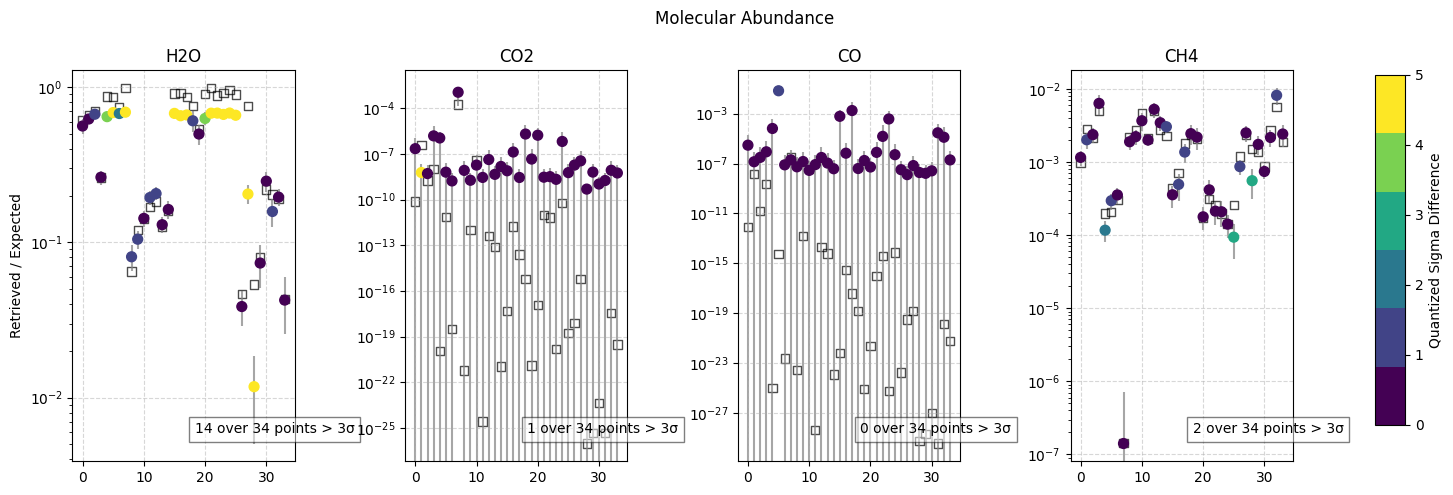

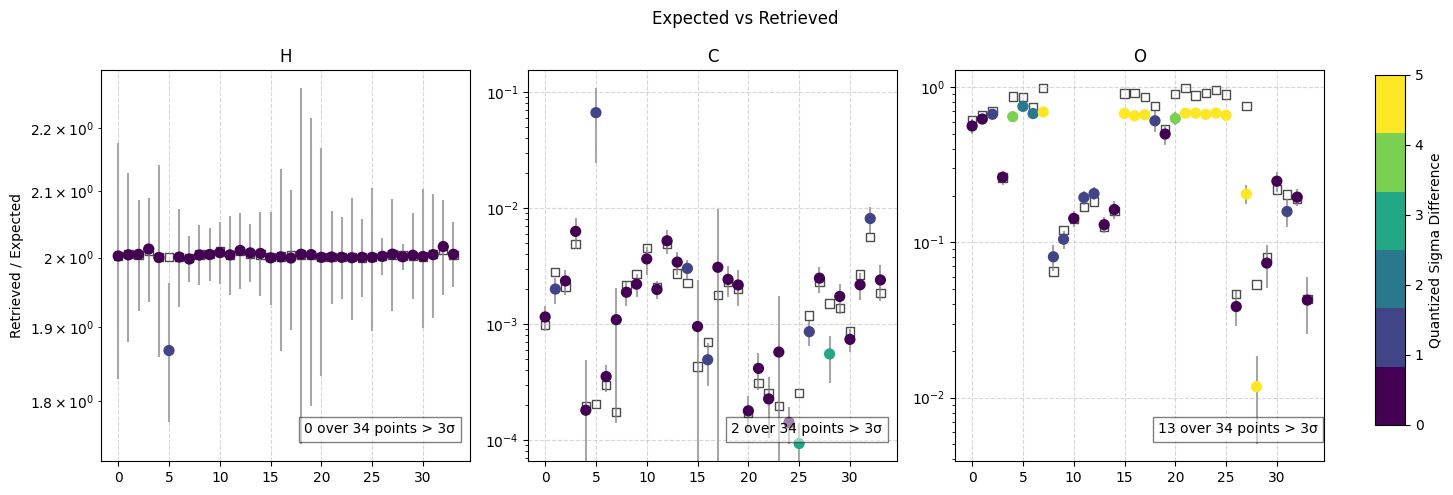

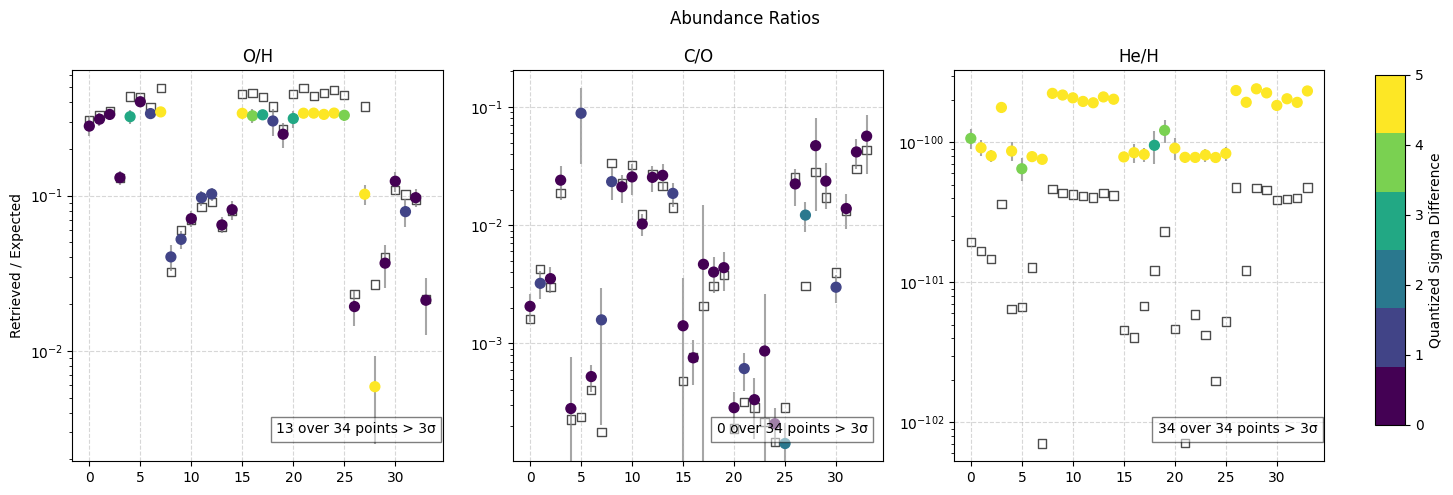

In [13]:
plot_comparison_panels(out_targetlist, keys=["H2O", "CO2", "CO", "CH4"], title="Molecular Abundance")

plot_comparison_panels(out_targetlist, keys=["H", "C", "O"], title="Expected vs Retrieved")

plot_comparison_panels(out_targetlist, keys=["O/H", "C/O", "He/H"], title="Abundance Ratios")



## notes

- water is failing because conditions are changed: we have priors on the water abundance up to 0.7, but inputs go up to 1.0. This is why the retrieval is failing. We need to fix this. 
- most of the O comes from water, so we need to fix this.


In [14]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MaxNLocator

def plot_scatter_with_histograms(
    data_table, x_key, y_key,
    x_err_key=None, y_err_key=None, color_key=None,
    cmap="viridis", hist_color="black", bins_num=30, marker="o",
    ax_scatter=None, ax_hist_x=None, ax_hist_y=None, ax_legend=None, fig=None,
    label=None, alpha=0.6, 
    err_color="black", elinewidth=1.5, capsize=3, capthick=1, errorevery=1, err_alpha=0.5, linestyle="-",
    global_norm=None
):
    """
    Creates or updates a scatter plot with histograms projected on the x and y axes.
    
    If axes are provided, it overlays new data on the existing plots.
    """
    x_data = np.array(data_table[x_key])
    y_data = np.array(data_table[y_key])
    x_err = np.array(data_table[x_err_key]) if x_err_key else None
    y_err = np.array(data_table[y_err_key]) if y_err_key else None
    color_data = np.array(data_table[color_key]) if color_key else None

    if global_norm is None and color_key is not None:
        global_norm = plt.Normalize(vmin=np.nanmin(color_data), vmax=np.nanmax(color_data))

    cmap_instance = plt.cm.get_cmap(cmap)
    scatter_color = cmap_instance(0.5) if color_key is None else None
    
    new_plot = False
    if ax_scatter is None or ax_hist_x is None or ax_hist_y is None:
        new_plot = True
        fig = plt.figure(figsize=(10, 8))
        gs = fig.add_gridspec(4, 5, hspace=0, wspace=0.1, width_ratios=[1, 1, 1, 1, 0.3])

        ax_scatter = fig.add_subplot(gs[1:4, 0:3])
        ax_hist_x = fig.add_subplot(gs[0, 0:3], sharex=ax_scatter)
        ax_hist_y = fig.add_subplot(gs[1:4, 3], sharey=ax_scatter)
        ax_legend = fig.add_subplot(gs[0, 3:5])
        ax_legend.axis("off")
        if color_key is not None:
            ax_colorbar = fig.add_subplot(gs[1:4, 4])

    scatter = ax_scatter.scatter(
        x_data, y_data, c=color_data if color_key else scatter_color, cmap=cmap, norm=global_norm,
        alpha=alpha, edgecolors="None", label=label, marker=marker, zorder=100
    )

    if x_err is not None or y_err is not None:
        for i in range(0, len(x_data), errorevery):
            ax_scatter.errorbar(
                x_data[i], y_data[i],
                xerr=x_err[i] if x_err is not None else None,
                yerr=y_err[i] if y_err is not None else None,
                alpha=err_alpha, fmt="o", color=cmap_instance(global_norm(color_data[i])) if color_data is not None else scatter_color,
                ecolor=err_color, elinewidth=elinewidth, capsize=capsize, capthick=capthick, linestyle=linestyle, zorder=1
            )

    bins_x = np.logspace(np.log10(np.nanmin(x_data)), np.log10(np.nanmax(x_data)), bins_num)
    bins_y = np.logspace(np.log10(np.nanmin(y_data)), np.log10(np.nanmax(y_data)), bins_num)
    
    hist_color_final = hist_color if color_key else scatter_color
    
    ax_hist_x.hist(x_data, bins=bins_x, edgecolor="black", alpha=0.7, label=label, color=hist_color_final)
    ax_hist_y.hist(y_data, bins=bins_y, orientation="horizontal", edgecolor="black", alpha=0.7, label=label, color=hist_color_final)
    
    ax_hist_x.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax_hist_y.xaxis.set_major_locator(MaxNLocator(integer=True))

    if new_plot:
        ax_scatter.set_xlabel(x_key, fontsize=14)
        ax_scatter.set_ylabel(y_key, fontsize=14)
        ax_scatter.set_title(f"Scatter Plot of {x_key} vs {y_key}", fontsize=16)
        ax_scatter.set_xscale("log")
        ax_scatter.set_yscale("log")
        plt.setp(ax_hist_x.get_xticklabels(), visible=False)
        plt.setp(ax_hist_y.get_yticklabels(), visible=False)
        ax_scatter.grid(True, linestyle="--", alpha=0.6)
        if color_key is not None:
            cbar = plt.colorbar(scatter, cax=ax_colorbar)
            cbar.set_label(color_key, fontsize=12)
            
        ax_scatter.grid(True, linestyle="--", alpha=0.5)

    
    
    if not new_plot:
        handles_scatter, labels_scatter = ax_scatter.get_legend_handles_labels()
        handles_hist_x, labels_hist_x = ax_hist_x.get_legend_handles_labels()
        
        # Merge legend entries
        handles = handles_scatter + handles_hist_x
        labels = labels_scatter + labels_hist_x
    
        if len(labels) > 1:  
            ax_legend.legend(handles, labels, loc="upper right", frameon=False)
 
    return fig, ax_scatter, ax_hist_x, ax_hist_y, ax_legend, global_norm


/tmp/ipykernel_348726/1973797243.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_instance = plt.cm.get_cmap(cmap)
/tmp/ipykernel_348726/1973797243.py:45: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  scatter = ax_scatter.scatter(
/tmp/ipykernel_348726/1973797243.py:45: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax_scatter.scatter(


Text(0.5, 0.98, 'Input values')

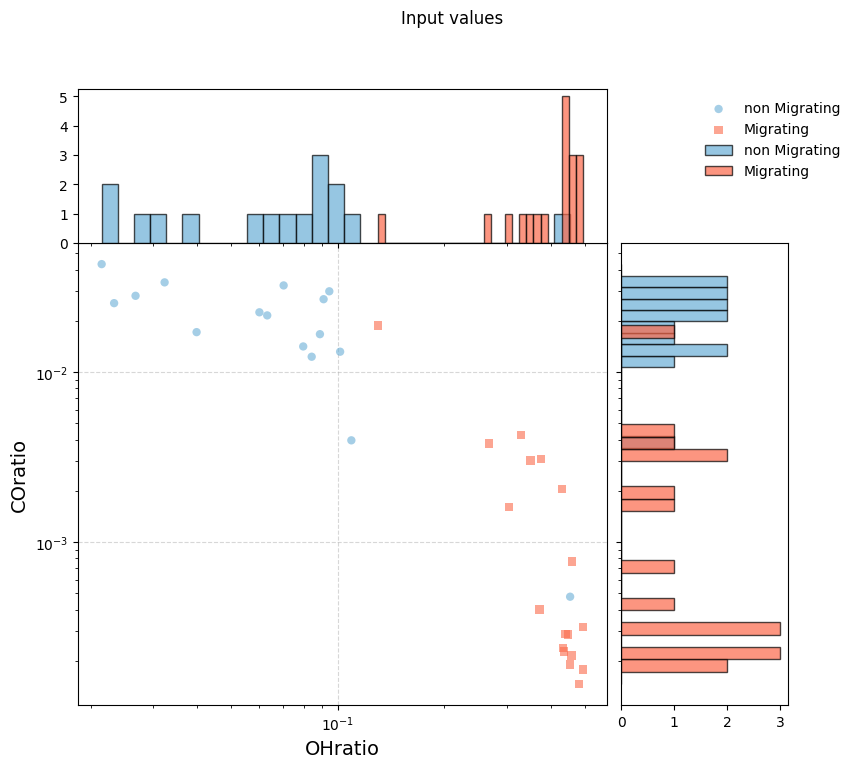

In [15]:


fig, ax_s, ax_hx, ax_hy, ax_leg, global_norm, = plot_scatter_with_histograms(
    out_targetlist[out_targetlist["Migration Efficiency [ Inefficient = 0, Efficient = 1]"]==0], "OHratio", "COratio",
    label="non Migrating", marker="o", cmap="Blues", hist_color="blue"
)

plot_scatter_with_histograms(
    out_targetlist[out_targetlist["Migration Efficiency [ Inefficient = 0, Efficient = 1]"]==1], "OHratio", "COratio",
    label="Migrating", marker="s", cmap="Reds", hist_color="red",
    ax_scatter=ax_s, ax_hist_x=ax_hx, ax_hist_y=ax_hy, ax_legend=ax_leg, fig=fig, global_norm=global_norm
)
fig.suptitle("Input values")

In [16]:
# # plot_scatter_with_histograms(out_targetlist, "C/O", "O/H")

# # plot_scatter_with_histograms(out_targetlist[out_targetlist["Redox [Oxidized = 0, Reduced =1]"]==1], "C/O", "O/H", x_err_key="C/O_sigma", y_err_key="O/H_sigma", color_key="He/H")
# plot_scatter_with_histograms(out_targetlist, "C/O", "O/H", x_err_key="C/O_sigma", y_err_key="O/H_sigma", color_key="He/H")

# plot_scatter_with_histograms(out_targetlist[out_targetlist["Redox [Oxidized = 0, Reduced =1]"]==0], "C/O", "O/H", x_err_key="C/O_sigma", y_err_key="O/H_sigma", color_key="Planet Semi-major Axis [m]")
# plot_scatter_with_histograms(out_targetlist[out_targetlist["Redox [Oxidized = 0, Reduced =1]"]==1], "C/O", "O/H", x_err_key="C/O_sigma", y_err_key="O/H_sigma", color_key="Planet Semi-major Axis [m]")



/tmp/ipykernel_348726/1973797243.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_instance = plt.cm.get_cmap(cmap)
/tmp/ipykernel_348726/1973797243.py:45: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  scatter = ax_scatter.scatter(
/tmp/ipykernel_348726/1973797243.py:45: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax_scatter.scatter(


Text(0.5, 0.98, 'Retrievals compared')

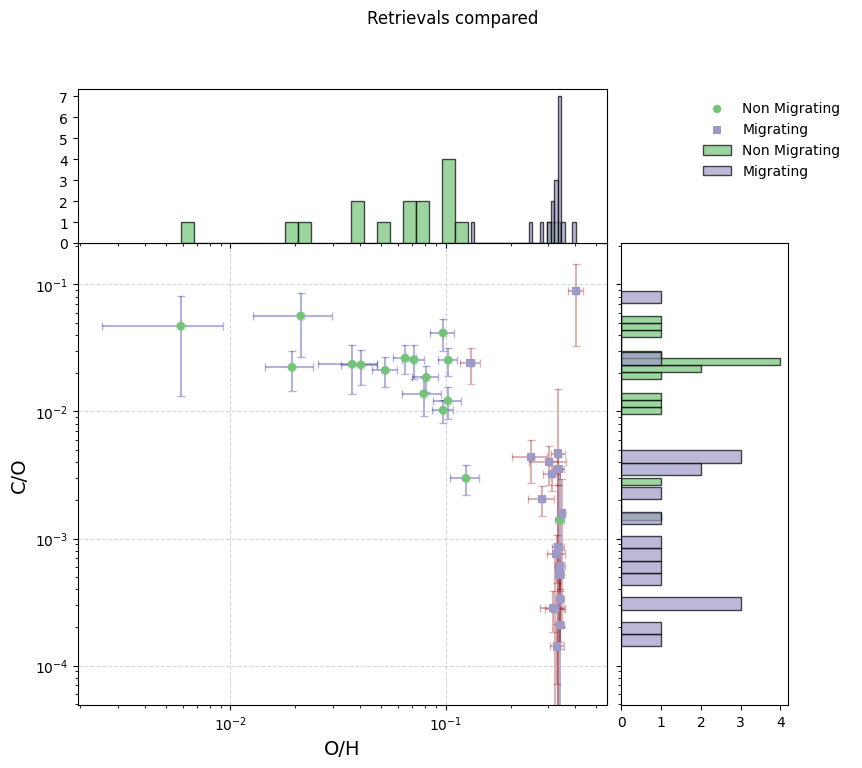

In [17]:
fig, ax_s, ax_hx, ax_hy, ax_leg, global_norm = plot_scatter_with_histograms(
    out_targetlist[out_targetlist["Migration Efficiency [ Inefficient = 0, Efficient = 1]"]==0], 
    x_key="O/H", y_key="C/O", 
    x_err_key="O/H_sigma", y_err_key="C/O_sigma", 
    # color_key="He/H", 
    label="Non Migrating", marker="o", cmap="Greens", hist_color="green", alpha=1,
    err_color="darkblue", elinewidth=1.5, capsize=3, capthick=1, errorevery=1, err_alpha=0.3
)

plot_scatter_with_histograms(
    out_targetlist[out_targetlist["Migration Efficiency [ Inefficient = 0, Efficient = 1]"]==1], 
    x_key="O/H", y_key="C/O", 
    x_err_key="O/H_sigma", y_err_key="C/O_sigma", 
    # color_key="He/H", 
    label="Migrating", marker="s", cmap="Purples", hist_color="purple", alpha=1,
    err_color="darkred", elinewidth=1.5, capsize=3, capthick=1, errorevery=1, err_alpha=0.3,
    ax_scatter=ax_s, ax_hist_x=ax_hx, ax_hist_y=ax_hy, ax_legend=ax_leg, global_norm=global_norm, fig=fig)

fig.suptitle("Retrievals compared")

/tmp/ipykernel_348726/1973797243.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_instance = plt.cm.get_cmap(cmap)
/tmp/ipykernel_348726/1973797243.py:45: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  scatter = ax_scatter.scatter(
/tmp/ipykernel_348726/1973797243.py:45: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax_scatter.scatter(


(<Figure size 1000x800 with 4 Axes>,
 <Axes: title={'center': 'Scatter Plot of O/H vs C/O'}, xlabel='O/H', ylabel='C/O'>,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 None)

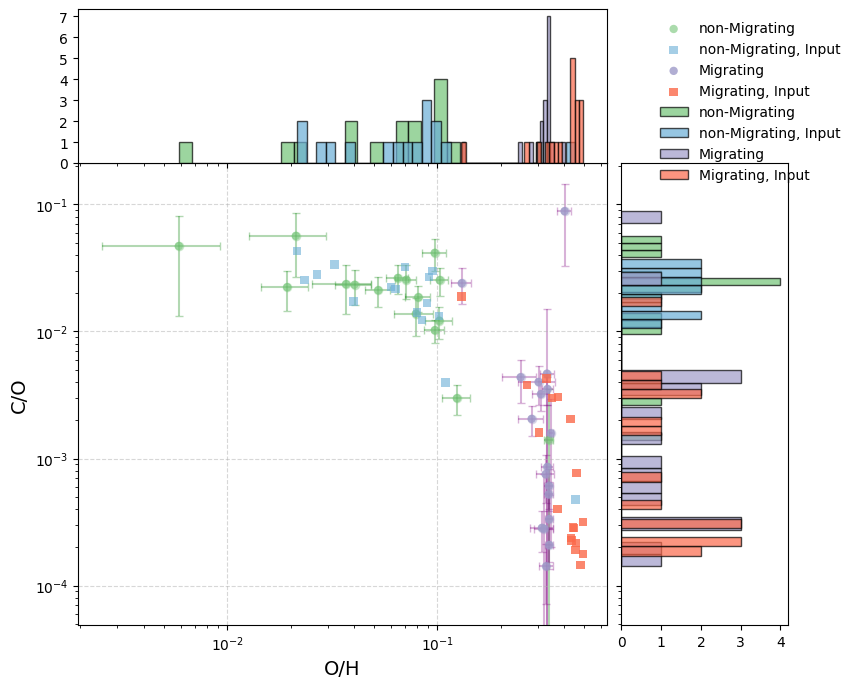

In [19]:
fig, ax_s, ax_hx, ax_hy, ax_leg, global_norm = plot_scatter_with_histograms(
    out_targetlist[out_targetlist["Migration Efficiency [ Inefficient = 0, Efficient = 1]"]==0], 
    x_key="O/H", y_key="C/O", 
    x_err_key="O/H_sigma", y_err_key="C/O_sigma", 
    label="non-Migrating", marker="o", cmap="Greens", hist_color="green",
    err_color="green", elinewidth=1.5, capsize=3, capthick=1, errorevery=1, err_alpha=0.3
)

plot_scatter_with_histograms(
    out_targetlist[out_targetlist["Migration Efficiency [ Inefficient = 0, Efficient = 1]"]==0], "OHratio", "COratio",
    label="non-Migrating, Input", marker="s", cmap="Blues", hist_color="orange",
    ax_scatter=ax_s, ax_hist_x=ax_hx, ax_hist_y=ax_hy, ax_legend=ax_leg, fig=fig)


plot_scatter_with_histograms(
    out_targetlist[out_targetlist["Migration Efficiency [ Inefficient = 0, Efficient = 1]"]==1], 
    x_key="O/H", y_key="C/O", 
    x_err_key="O/H_sigma", y_err_key="C/O_sigma", 
    label="Migrating", marker="o", cmap="Purples", hist_color="purple", alpha=0.8,
    err_color="purple", elinewidth=1.5, capsize=3, capthick=1, errorevery=1, err_alpha=0.3,
    ax_scatter=ax_s, ax_hist_x=ax_hx, ax_hist_y=ax_hy, ax_legend=ax_leg, fig=fig)


plot_scatter_with_histograms(
    out_targetlist[out_targetlist["Migration Efficiency [ Inefficient = 0, Efficient = 1]"]==1], "OHratio", "COratio",
    label="Migrating, Input", marker="s", cmap="Reds", hist_color="red", alpha=0.8,
    ax_scatter=ax_s, ax_hist_x=ax_hx, ax_hist_y=ax_hy, ax_legend=ax_leg, fig=fig)

